# XGBoost Validation

In [ ]:
!python --version

Python 3.10.6


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install xgboost

In [ ]:
#imports
print("Starting imports")
#basics
import time
print("Starting timer.")
startTime = time.time()

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns

#cleaning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


#XGBoost Specific
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute

#hyperparams
from sklearn.model_selection import GridSearchCV

#h5 conversion
import h5py

#import validation tests
from scipy.spatial.distance import euclidean, cityblock
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from sklearn.model_selection import KFold

print("Imports Complete")

Starting imports
Starting timer.
Imports Complete


In [ ]:
datetimeCurr = datetime.datetime.now().strftime("%y%M%d_%H%M%S")
print(f"Current Datetime File Association: {datetimeCurr}")

Current Datetime File Association: 230726_160716


## Get Data

In [ ]:
#paths
mainPath = '/content/gdrive/MyDrive/REU 2023 Team 1: Ice Bed Topography Prediction/Research/Yi_Work'
data_full_ = mainPath + '/Bilinear/data_full_bilinear_vMag.csv' #training and test combined
data_1201_ = mainPath + '/Data_derivedVelocity/d1201_vMag.csv'
validation1201_ = mainPath + '/Bilinear/Copy of bed_BedMachine.h5' #physics model provided

In [ ]:
#read data in
# df_train = pd.read_csv(df_train_)
# df_test_x = pd.read_csv(df_test_)
# df_test_y = pd.read_csv(df_pred_)

print("Reading Data In_")
df_all = pd.read_csv(data_full_)

df1201 = pd.read_csv(data_1201_)

# physSol = pd.DataFrame(np.array(h5py.File(validation1201_)['bed_BedMachine'])) #physics 1201
print("Data read in completed.")

Reading Data In_
Data read in completed.


In [ ]:
physSol = pd.DataFrame(np.array(h5py.File(validation1201_)['bed_BedMachine'])) #physics 1201


## Create functions from Homayra

In [ ]:
print("Establishing RMSPE functions.")

Establishing RMSPE functions.


In [ ]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

In [ ]:
def rmspe_1(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(y_true - y_pred) / y_true))*100

In [ ]:
print("Function established.")

Function established.


## Clean Data/Prepare Data

In [ ]:
df1201.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'surf_x', 'surf_y', 'surf_vx', 'surf_vy',
       'surf_dhdt', 'surf_SMB', 'surf_elv', 'v_mag'],
      dtype='object')

In [ ]:
print("Begin data cleaning.")

# df1201 = df1201.drop(columns = ['Unnamed: 0.1'])
# df_all = df_all.drop(columns = ['Unnamed: 0'])

#1201 drop location variables
df1201_feats = df1201.drop(columns = ['surf_x', 'surf_y'])

#df_all drop location variables
df_all_feats_target = df_all.drop(columns = ['track_bed_x', 'track_bed_y'])

#1201 order to align with df_all
df1201_feats_ordered = df1201_feats[[ 'surf_vx', 'surf_vy', 'surf_dhdt', 'surf_SMB', 'surf_elv', 'v_mag']]

#set the feature variables to our independent characteristic variables
feature_cols = [ 'surf_vx', 'surf_vy', 'surf_dhdt', 'surf_SMB', 'surf_elv', 'v_mag']

#split into X and Y
X_given = df_all_feats_target[feature_cols]
Y_given = df_all_feats_target['track_bed_target']

#combine all known X and validation 1201 X for standardizing
# X_all = X_given
X_all = np.concatenate((X_given, df1201_feats_ordered))
#make y into a dataframe to be standardized
Y_all = pd.DataFrame(Y_given)

print("Data cleaned.\nScaling beginning.")

#standardize
#Not setting feature range, let it be automatically determined
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_all_std = scaler_X.fit_transform(X_all)
Y_all_std = scaler_Y.fit_transform(Y_all)

#can alternatively use the MinMaxScaler
print("Scaling Complete.\nSplitting Data Beginning.")

#split of 1201 data from X_all_std
X_non1201 = X_all_std
X_non1201 = X_all_std[0:632706,:]
X_1201_data = X_all_std[632706:, :]

# #generate a randomseed for training and testing split
# generated = np.random.randint(0,1000,1)[0]
# print(f"Generated random split for train-test: {generated}")
# # #generated = #
generated = 168

#set the train-test split
#60-40 showed the most promising from previous research and additional testing
train_size_ = .6
#split training and test from df_all
x_train, x_test, y_train, y_test = train_test_split(X_non1201, Y_all_std, train_size = train_size_, test_size = 1-train_size_, random_state = generated)

#get validation data
val_split = .2 #can change as needed
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 1-val_split, test_size = val_split, random_state = generated)

print(f"Data train-split complete with: {train_size_ * 100}% training, {(1- train_size_) * 100}% testing, {val_split*100}% validation")

Begin data cleaning.
Data cleaned.
Scaling beginning.
Scaling Complete.
Splitting Data Beginning.
Data train-split complete with: 60.0% training, 40.0% testing, 20.0% validation


## Modeling

In [ ]:
depth_ = 7 #higher --> Lower RMSE; lower --> more extreme highs and lows
iters_ = 350 #higher is higher R^2 and more reflection on the detail
eta_ = .25 #higher is more overfitting

In [ ]:
#define
model = XGBRegressor(
    max_depth=depth_,
    n_estimators=iters_,
    min_child_weight=0.25,
    subsample=0.8,
    eta=eta_,
    seed=generated)

In [ ]:
%%time
model.fit(
    x_train,
    y_train,
    eval_set=[(x_val, y_val)],
    verbose=False
    )

CPU times: user 6min 27s, sys: 545 ms, total: 6min 27s
Wall time: 3min 56s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.25, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=0.25, missing=nan,
             monotone_constraints=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [ ]:
%%time
print("Model Prediction Beginning")
y_pred_test = model.predict(x_test)

print("Model predicted.\nTransform data back to original scale.")

#get the original scale for the predicted Y
test_predict_full_scale = scaler_Y.inverse_transform(y_pred_test.reshape(-1,1))
y_test_given_full_range = scaler_Y.inverse_transform(y_test.reshape(-1,1))

Model Prediction Beginning
Model predicted.
Transform data back to original scale.
CPU times: user 3.93 s, sys: 13.8 ms, total: 3.95 s
Wall time: 2.71 s


In [ ]:
# Evaluate the model performance
print("Print bilinear testing stats statements.")

#LOSSES
print('RMSE:',np.sqrt(mean_squared_error(y_test_given_full_range, test_predict_full_scale)))
# print('RMSE Percentage:',rmspe(y_test_given_full_range, test_predict_full_scale))
# print('RMSE Percentage-1:',rmspe_1(y_test_given_full_range, test_predict_full_scale))
print('Mean Absolute Error:', mean_absolute_error(y_test_given_full_range, test_predict_full_scale))
# print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test_given_full_range, test_predict_full_scale))
print('R^2 Score:', r2_score(y_test_given_full_range, test_predict_full_scale))

Print bilinear testing stats statements.
RMSE: 27.734627348311506
Mean Absolute Error: 18.35248703990835
R^2 Score: 0.9762807866111508


In [ ]:
%%time
# Evaluate the combined model on the non-bias training data

# Pass the latent samples through the decoder
y_pred_val = model.predict(x_val)

#rescale
val_predict_full_scale = scaler_Y.inverse_transform(y_pred_val.reshape(-1,1))
y_val_given_full_range = scaler_Y.inverse_transform(y_val.reshape(-1,1))

# Evaluate the model performance
print("Print bilinear validation stats statements.")

#LOSSES
print('RMSE:',np.sqrt(mean_squared_error(y_val_given_full_range, val_predict_full_scale)))
print('RMSE Percentage:',rmspe(y_val_given_full_range, val_predict_full_scale))
print('Mean Absolute Error:', mean_absolute_error(y_val_given_full_range, val_predict_full_scale))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_val_given_full_range, val_predict_full_scale))
print('R^2 Score:', r2_score(y_val_given_full_range, val_predict_full_scale))

Print bilinear validation stats statements.
RMSE: 27.30672448164108
RMSE Percentage: 10744.410624895967
Mean Absolute Error: 18.22007376592227
Mean Absolute Percentage Error: 0.7663631795314992
R^2 Score: 0.9766704330972472
CPU times: user 1.25 s, sys: 2.93 ms, total: 1.25 s
Wall time: 863 ms


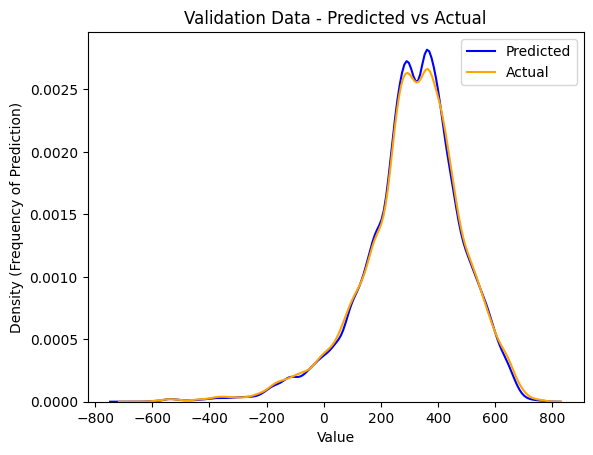

In [ ]:
sns.kdeplot(val_predict_full_scale.flatten(), label='Predicted', color = "blue")
sns.kdeplot(y_val_given_full_range.flatten(), label='Actual', color = "orange")
plt.xlabel('Value')
plt.ylabel('Density (Frequency of Prediction)')
plt.title('Validation Data - Predicted vs Actual')
plt.legend()

### 1201 Prediction

In [ ]:
print("Predicting 1201")
start1201Prediction = time.time()

y_pred_1201 = model.predict(X_1201_data)
pred1201_normScale = scaler_Y.inverse_transform(y_pred_1201.reshape(-1,1))

end1201Prediction = time.time()
print(f"Predicting 1201 Complete.\nTime taken: {end1201Prediction-start1201Prediction:.03f}ms")

Predicting 1201
Predicting 1201 Complete.
Time taken: 15.669ms


In [ ]:
print("Converting 1201 prediction 1201 shape.")

y_Predict_1201_full_flatten=pred1201_normScale.flatten()
prediction_on_1201_2D=y_Predict_1201_full_flatten.reshape(1201,1201)

print("1201 ready for validation checks.")

Converting 1201 prediction 1201 shape.
1201 ready for validation checks.


## Validation

In [ ]:
d1201Comparison = pd.DataFrame(prediction_on_1201_2D)

In [ ]:
#transpose the datasets to face the correct NSEW directions.
data_set1 = np.transpose(d1201Comparison)
data_set1 = np.flipud(data_set1)
data_set2 = np.transpose(physSol) #solution
data_set2 = np.flipud(data_set2)

Current Datetime File Association: 230726_163944


<ipython-input-48-8ffd5cafd21a>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,0].set_yticklabels(reversed(axs[0,0].get_yticklabels()))  # Reverse the y-axis tick labels
<ipython-input-48-8ffd5cafd21a>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,1].set_yticklabels(reversed(axs[0,1].get_yticklabels()))  # Reverse the y-axis tick labels


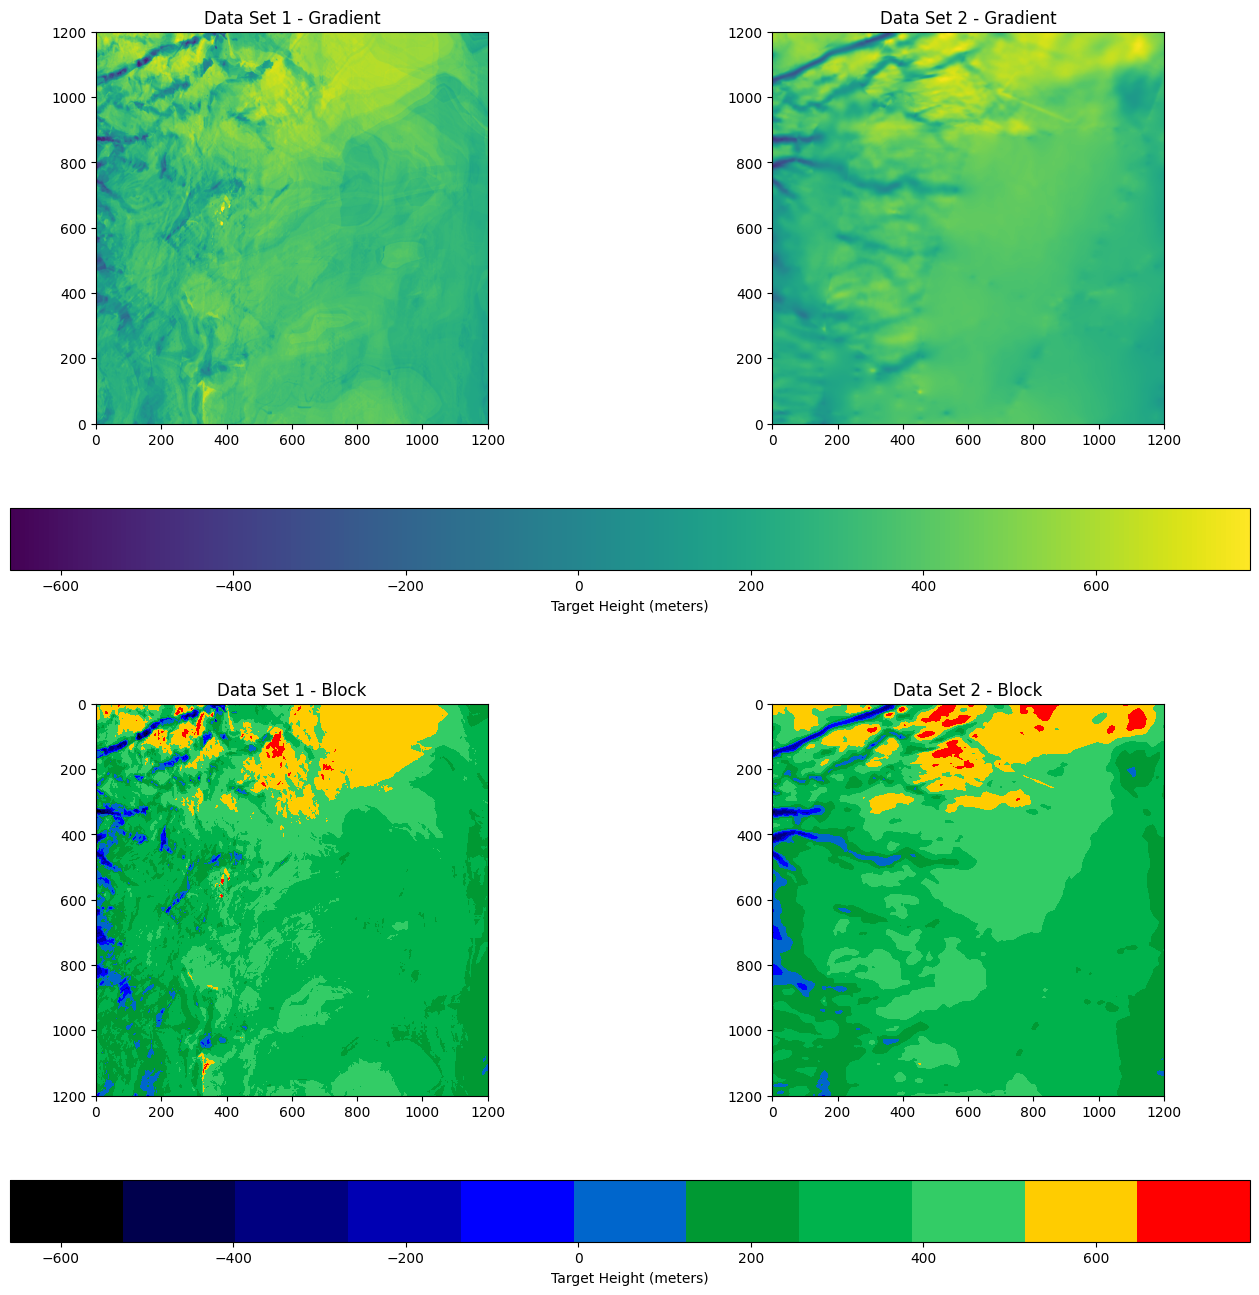

In [ ]:
datetimeCurr = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
print(f"Current Datetime File Association: {datetimeCurr}")

# Determine the minimum and maximum values for both data sets
min_value = min(data_set1.flatten().min(), data_set2.flatten().min())
max_value = data_set2.flatten().max()

# Create a figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

# Plot the first data set with shared color scale
im1 = axs[0,0].imshow(data_set1, vmin=min_value, vmax=max_value)
axs[0,0].set_title('Data Set 1 - Gradient')
axs[0,0].set_yticklabels(reversed(axs[0,0].get_yticklabels()))  # Reverse the y-axis tick labels


# Plot the second data set with shared color scale
im2 = axs[0,1].imshow(data_set2, vmin=min_value, vmax=max_value)
axs[0,1].set_title('Data Set 2 - Gradient')
axs[0,1].set_yticklabels(reversed(axs[0,1].get_yticklabels()))  # Reverse the y-axis tick labels

# Define the colormap
colors = [
    (0.0, 0.0, 0.0),    # Black
    (0.0, 0.0, 0.3),    # Darker blue
    (0.0, 0.0, 0.5),    # Dark blue
    (0.0, 0.0, 0.7),    # blue
    (0.0, 0.0, 1.0),    # Blue
    (0.0, 0.4, 0.8),    # Lighter blue
    (0.0, 0.6, 0.2),    # Dark green
    (0.0, 0.7, 0.3),    # Green
    (0.2, 0.8, 0.4),    # Light green
    (1.0, 0.8, 0.0),    # Orange
    (1.0, 0.0, 0.0),    # Red
]
mapColor = LinearSegmentedColormap.from_list('WaterTreesMountains', colors)

#PLOT WITH BLOCK Color
cmap = ListedColormap(colors)

im3 = axs[1, 0].imshow(data_set1, vmin=min_value, vmax=max_value, cmap=cmap)
axs[1, 0].set_title('Data Set 1 - Block')

# Plot the second data set with block color scale
im4 = axs[1, 1].imshow(data_set2, vmin=min_value, vmax=max_value, cmap=cmap)
axs[1, 1].set_title('Data Set 2 - Block')

# Add colorbars to the plots
fig.colorbar(im2, label="Target Height (meters)", ax=axs[0, :], location='bottom')
fig.colorbar(im4, label="Target Height (meters)", ax=axs[1, :], location='bottom')

# Save & Display the plot
# plt.savefig(saveMapTo_ + f"/XGBT4M_Results_{datetimeCurr}_D{depth_}I{iters_}E{eta_}.png")
plt.show()

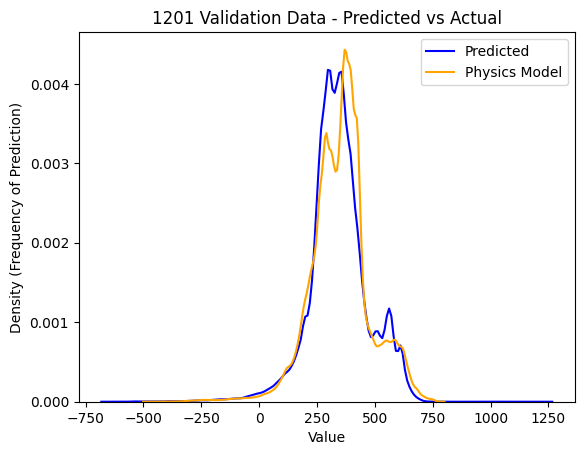

In [ ]:
sns.kdeplot(data_set1.flatten(), label='Predicted', color = "blue")
sns.kdeplot(data_set2.flatten(), label='Physics Model', color = "orange")
plt.xlabel('Value')
plt.ylabel('Density (Frequency of Prediction)')
plt.title('1201 Validation Data - Predicted vs Actual')
plt.legend()

<ipython-input-50-a676c7b8d5a8>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(reversed(axs.get_yticklabels()))  # Reverse the y-axis tick labels


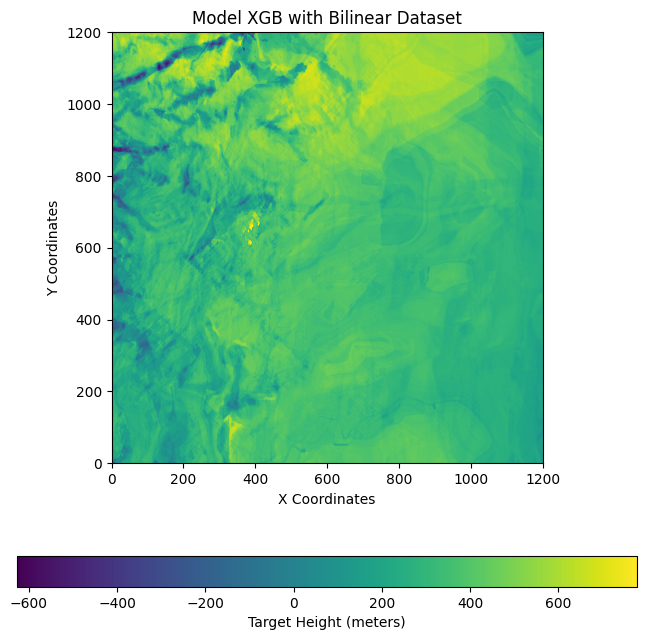

In [ ]:
modelNameYoureRunning = "XGB"
interpolatedDataYoureRunning = "Bilinear"

figRunName = f"Model {modelNameYoureRunning} with {interpolatedDataYoureRunning} Dataset"
min_value = -626.96027
max_value = 778.96765

# Create a figure and subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# Assuming data_set1 is defined and contains your data
# Plot the first data set with shared color scale
im1 = axs.imshow(data_set1, vmin=min_value, vmax=max_value)
axs.set_title(f'{figRunName}')
axs.set_yticklabels(reversed(axs.get_yticklabels()))  # Reverse the y-axis tick labels
axs.set_xlabel("X Coordinates")
axs.set_ylabel("Y Coordinates")

# Define the colormap
colors = [
    (0.0, 0.0, 0.0),    # Black
    (0.0, 0.0, 0.3),    # Darker blue
    (0.0, 0.0, 0.5),    # Dark blue
    (0.0, 0.0, 0.7),    # Blue
    (0.0, 0.0, 1.0),    # Blue
    (0.0, 0.4, 0.8),    # Lighter blue
    (0.0, 0.6, 0.2),    # Dark green
    (0.0, 0.7, 0.3),    # Green
    (0.2, 0.8, 0.4),    # Light green
    (1.0, 0.8, 0.0),    # Orange
    (1.0, 0.0, 0.0),    # Red
]
mapColor = LinearSegmentedColormap.from_list('WaterTreesMountains', colors)

# Add colorbar to the plot
fig.colorbar(im1, label="Target Height (meters)", ax=axs, location='bottom')

plt.show()
plt.close()


## TRI Scores

In [ ]:
import numpy as np
from scipy.ndimage import generic_filter

def calculate_tri(elevation_values):
    def local_tri(arr):
        center = arr[int(len(arr)/2)]  # Center cell
        differences = arr - center
        squared_diff = np.square(differences)
        average_squared_diff = np.mean(squared_diff)
        tri = np.sqrt(average_squared_diff)
        return tri

    tri = generic_filter(elevation_values, local_tri, size=3) #gets closest 8 points.
    return tri

In [ ]:
#ALTERNATE, RESCALED TO NORMAL
rescaled = scaler_Y.inverse_transform(y_val.reshape(-1,1))
tri_known = calculate_tri(rescaled)

#ALTERNATE, RESCALED TO NORMAL
rescaled = scaler_Y.inverse_transform(y_pred_val.reshape(-1,1))
tri_predicted_val = calculate_tri(rescaled)

In [ ]:
%%time
# COMPARE TRI SCORES - VALIDATION ONLY

# Evaluate the model performance
print("Print Terrain Roughness Index on Kriging Stats statements.")
print("USING  WORLD SCALE - NOT SCALED DOWN")

print(f"Known TRI:\nMean: {round(tri_known.mean(),3)}\nMin, Max: {round(tri_known.min(),3)}, {round(tri_known.max(),3)}")
print(f"Predicted TRI:\nMean: {round(tri_predicted_val.mean(),3)}\nMin, Max: {round(tri_predicted_val.min(),3)}, {round(tri_predicted_val.max(),3)}")

#LOSSES
print("*****")
print('RMSE:',np.sqrt(mean_squared_error(tri_known, tri_predicted_val)))
# print('RMSE Percentage:',rmspe(tri_known, tri_predicted_val))
print('Mean Absolute Error:', mean_absolute_error(tri_known, tri_predicted_val))
# print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(tri_known, tri_predicted_val))
print('R^2 Score:', r2_score(tri_known, tri_predicted_val))
print("*****")

Print Terrain Roughness Index on Kriging Stats statements.
USING  WORLD SCALE - NOT SCALED DOWN
Known TRI:
Mean: 173.404
Min, Max: 0.994, 951.089
Predicted TRI:
Mean: 168.38400268554688
Min, Max: 0.6470000147819519, 945.176025390625
*****
RMSE: 24.84701344105336
Mean Absolute Error: 17.32603411719647
R^2 Score: 0.950296389052055
*****
CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 14.3 ms


In [ ]:
#TRI 1201
tri_predicted_1201 = calculate_tri(prediction_on_1201_2D)
print(f"Predicted TRI:\nMean: {round(tri_predicted_1201.mean(),3)}")

Predicted TRI:
Mean: 14.682000160217285


In [ ]:
endTime = time.time()
print(f"Total Time Taken: {endTime - startTime:.03f}ms")
print("XGB Mag BILINEAR COMPLETE")

Total Time Taken: 1716.351ms
XGB Mag BILINEAR COMPLETE
